In [1]:
import torch
import torchvision.transforms as T
from PIL import Image

# from featup.util import norm, unnorm
# from featup.plotting import plot_feats, plot_lang_heatmaps
from dataloader_training import SpinalCordDataset, SpinalCordTransform
from model import SegmentationCNN
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import os
from glob import glob
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss, DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Activations, AsDiscrete, Compose
from monai.utils.enums import MetricReduction
from lr_scheduler import LinearWarmupCosineAnnealingLR
from functools import partial
from trainer_unet import run_training
from argparse import Namespace
import sys
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nb
from skimage import filters
from scipy.ndimage import zoom
import csv

In [2]:
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
model = SegmentationCNN()

# Load the checkpoint
checkpoint = torch.load("/home/sarvagya-pc/Desktop/FeatUp/test/model_final_first_500_epochs.pt")
# checkpoint = torch.load("/home/sarvagya-pc/Desktop/FeatUp/test/model_final.pt")

# Adjust the output layer weights
state_dict = checkpoint["state_dict"]

# Load the remaining weights into the model
model.load_state_dict(state_dict, strict=False)

# Set model to evaluation mode
model.eval()
model.cuda()

print("Model loaded and output layer reinitialized successfully.")

dice_score_total = []
total_area = []

Model loaded and output layer reinitialized successfully.


/tmp/ipykernel_3413247/2726068940.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/home/sarvagya-pc/Desktop/FeatUp/test/model_final_first_500_ep

In [6]:
# folder = "/home/sarvagya-pc/Desktop/Balgrist_neuroimg/featup/data/test/"
folder = "/home/sarvagya-pc/Desktop/Balgrist_neuroimg/featup/data/hr/sub_wise"
# subs = sorted(os.listdir(folder))
# dice_thresh = [0.8, 0.8, 0.8, 0.8, 0.2, 0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

sub = "sub-81"
ses = "ses-01"
image_npz_test = sorted(glob(folder+'/'+'featup_imgs_'+sub+'_'+ses+'.npz'))
label_npz_test = sorted(glob(folder+'/'+'labels_'+sub+'_'+ses+'.npz'))
print(image_npz_test)
area_each_ses = []
total_area = []

test_transform = SpinalCordTransform(target_size=(224, 224), flip_prob=0.0)
test_dataset = SpinalCordDataset(image_paths=image_npz_test, label_paths=label_npz_test, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

for batch in test_loader:
    images = batch["image"]  # Shape: (batch_size, 20, 3, 96, 96)
    labels = batch["label"]  # Shape: (batch_size, 20, 1, 96, 96)
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break

for idx, batch_data in enumerate(test_loader):
    print(idx)

    if isinstance(batch_data, list):
        data, target = batch_data
    else:
        data, target = batch_data["image"], batch_data["label"]
    data, target = data.cuda(), target.cuda()
    print("BEFORE TRANSFORM: ", data.shape)
    data = data.permute(0, 2, 3, 4, 1)
    target = target.permute(0, 2, 3, 4, 1)
    # data = data.repeat(1, 3, 1, 1)
    print("IN THE MODEL: ", data.shape)
    # hr_feats = model_1(data)
    logits = model(data)
    print("LOGITS: ", logits.shape)
    print("TARGET: ", target.shape)
    temp_logits = logits.detach().cpu().numpy()
    np.savez("/home/sarvagya-pc/Desktop/Balgrist_neuroimg/featup/data/hr/sub_wise/logits_"+sub+'_'+ses+"_testing_for_nii.npz", temp_logits)


['/home/sarvagya-pc/Desktop/Balgrist_neuroimg/featup/data/hr/sub_wise/featup_imgs_sub-81_ses-01.npz']
Image batch shape: torch.Size([1, 20, 384, 224, 224])
Label batch shape: torch.Size([1, 20, 1, 224, 224])
0
BEFORE TRANSFORM:  torch.Size([1, 20, 384, 224, 224])
IN THE MODEL:  torch.Size([1, 384, 224, 224, 20])
LOGITS:  torch.Size([1, 1, 224, 224, 20])
TARGET:  torch.Size([1, 1, 224, 224, 20])


In [7]:
num_slices = logits.shape[-1]  # Number of slices in the depth dimension
temp_dice = []
temp_area = []
for i in range(num_slices):
    # plt.figure(figsize=(5, 5))
    # plt.imshow(np.rot90(images[0, 0, :, :, i].cpu().numpy()), cmap="gray", alpha=0.8)
    x = logits[0, 0, :, :, i].detach().cpu().numpy()
    x = (x>0.9)*1
    # x = (x>dice_thresh[i])*1
    area_x = 0.25*np.sum(np.ndarray.flatten(x))
    # print(type(labels[0,0,:,:,i]))
    # print(type(x))
    score = dice_score(labels[0,i,0,:,:], torch.tensor(x))
    print(score)
    if np.isnan(score):
        score = 1
        temp_dice.append(score)
    else:
        temp_dice.append(score)
    temp_area.append(area_x)
dice_score_total.append(temp_dice)
total_area.append(temp_area)
temp_area = []
temp_dice = []

nan
nan
nan
nan
nan
nan
nan
0.5538461804389954
0.40993788838386536
0.7284144163131714
0.7648578882217407
0.724245548248291
0.9087403416633606
0.908687949180603
0.8905394673347473
0.9262394309043884
0.9305847883224487
0.9419795274734497
0.9324200749397278
0.9238234162330627


In [13]:
# with open('dice_score_featup_model_epochs_1000.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerows(dice_score_total)


# with open('area_featup_model_epochs_1000.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerows(total_area)

In [14]:
# total_area

In [8]:
orig_images = nb.load("/home/sarvagya-pc/Desktop/Balgrist_neuroimg/for_test/"+sub+"/"+ses+"/anat/"+sub+"_"+ses+"_acq-lumbarMEGRE3D_desc-crop_T2starw.nii").get_fdata()
orig_file_data = nb.load("/home/sarvagya-pc/Desktop/Balgrist_neuroimg/for_test/"+sub+"/"+ses+"/anat/"+sub+"_"+ses+"_acq-lumbarMEGRE3D_desc-crop_T2starw.nii")
print(orig_images.shape)

(97, 97, 20)


In [11]:
orig_file_data.affine

(4, 4)

In [12]:
# idx = 
pred_seg = logits[0,0,:,:,:].detach().cpu().numpy()
print(pred_seg.shape)
# x = (pred_seg>0.5)*1
# print(pred_seg.shape)
# # plt.imshow(pred_seg)
# plt.imshow(x)

(224, 224, 20)


In [13]:
orig_seg = labels[0,:,0,:,:].detach().cpu().numpy()
print(orig_seg.shape)
# plt.imshow(orig_seg)

(20, 224, 224)


In [14]:
zoom_factors_image = (
    224 / 97,
    224 / 97
)
overlap_alpha = 0.2

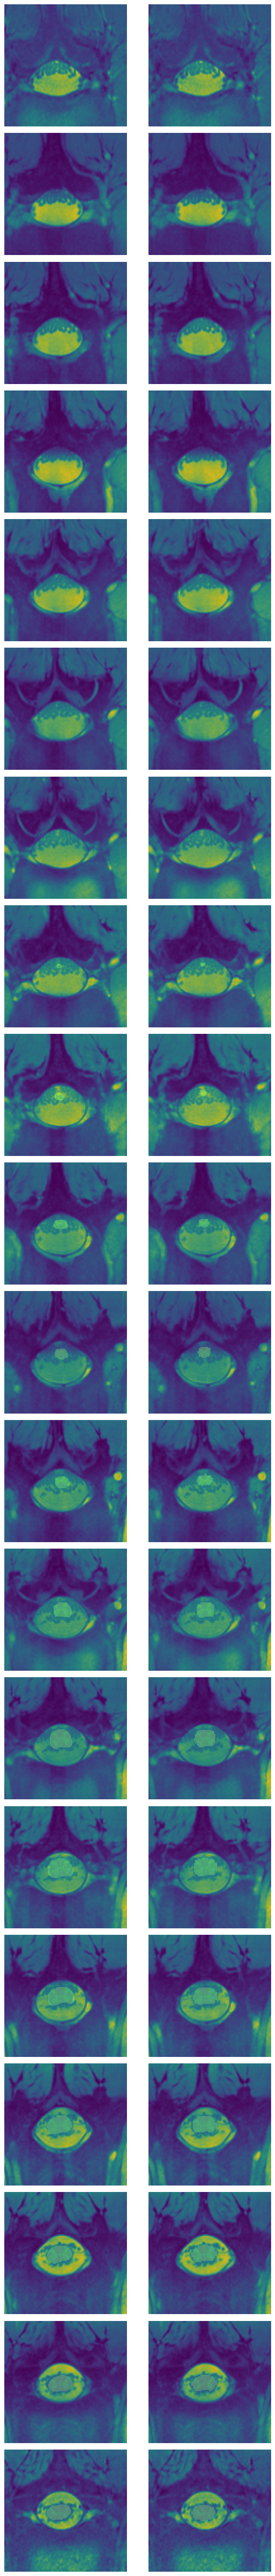

In [15]:
import matplotlib.pyplot as plt

# Assuming 'images_array1' and 'images_array2' are your two arrays of images
# Each array contains 20 images

fig, axes = plt.subplots(20, 2, figsize=(8, 60))  # Adjust figsize as needed
fig.subplots_adjust(hspace=0.3, wspace=0.1)

for i in range(20):
    resized_image = zoom(np.fliplr(np.rot90(orig_images[:,:,i], k=-1)), zoom_factors_image, order=1)
    # Plot image from the first array in the left column
    image_my_pred = np.copy(resized_image)
    image_ground_truth = np.copy(resized_image)
    # image_my_pred[np.where(filters.sobel(pred_seg[:,:,i]>0.6)*1)] = 0
    # image_ground_truth[np.where(filters.sobel(orig_seg[i]))] = 0

    # image_my_pred[np.where((pred_seg[:,:,i]>0.6)*1)] = 0
    # image_ground_truth[np.where((orig_seg[i]))] = 0
    
    # Im_pred = Image.fromarray(pred_seg[:,:,i])
    # Im_orig = Image.fromarray(orig_seg[i])
    # Im_gt = Image.fromarray(resized_image)

    new_img_pred = (pred_seg[:,:,i]>0.6)*0.9 + image_my_pred*0.1

    # new_img_pred = Image.blend(Im_pred, Im_gt, 0.5)
    # new_img_pred = np.array(new_img_pred)
    # axes[i, 0].imshow(filters.sobel(pred_seg[:,:,i]>0.6)*1)
    axes[i,0].imshow(image_my_pred)
    axes[i,0].imshow(pred_seg[:,:,i]>0.9, alpha=overlap_alpha)
    # axes[i,0].imshow((pred_seg[:,:,i]>0.6)*1)
    axes[i, 0].axis('off')
    
    # Plot image from the second array in the middle column
    # axes[i, 1].imshow(filters.sobel(orig_seg[i]))
    axes[i,1].imshow(image_ground_truth)
    axes[i,1].imshow(orig_seg[i], alpha=overlap_alpha)
    axes[i, 1].axis('off')

    # # Plot image from the second array in the right column
    # axes[i, 2].imshow(np.fliplr(np.rot90(orig_images[:,:,i], k=-1)))
    # axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# print(pred_seg[:,:,15].shape)
# print(zoom(filters.sobel(pred_seg[:,:,15]>0.6)*1, zoom_factors_label, order=0).shape)
# print(orig_seg[15].shape)
# print(orig_images[:,:,15].shape)

In [24]:
seg_array = np.zeros((224,224,20))
zoom_factors_image = (
    224 / 97,
    224 / 97
)
overlap_alpha = 0.2
for i in range(20):
    resized_image = zoom(np.fliplr(np.rot90(orig_images[:,:,i], k=-1)), zoom_factors_image, order=1)
    # resized_image = zoom(pred_seg[:,:,i]>0.3, zoom_factors_image, order=1)
    # resized_image = pred_seg[:,:,i]>0.3
    resized_image = np.fliplr(np.rot90(resized_image, k=-1))
    seg_array[:,:,i] = resized_image

# affine = np.eye(4)
nifti_file = nb.Nifti1Image(seg_array, orig_file_data.affine)
nb.save(nifti_file, "original_scan_224")

In [22]:
# converted_array = numpy.array(normal_array, dtype=numpy.float32)
# seg_array = np.zeros((97,97,20))
seg_array = np.zeros((224,224,20))
zoom_factors_image = (
    97 / 224,
    97 / 224
)
for i in range(20):
    # resized_image = zoom(pred_seg[:,:,i]>0.3, zoom_factors_image, order=1)
    resized_image = pred_seg[:,:,i]>0.3
    resized_image = np.fliplr(np.rot90(resized_image, k=-1))
    seg_array[:,:,i] = resized_image

# affine = np.eye(4)
nifti_file = nb.Nifti1Image(seg_array, orig_file_data.affine)
nb.save(nifti_file, "FeatUp_output_affine_orig")

In [29]:
orig_images = nb.load("/home/sarvagya-pc/Desktop/Balgrist_neuroimg/for_test/"+sub+"/"+ses+"/anat/"+sub+"_"+ses+"_acq-lumbarMEGRE3D_desc-crop_seg-manual_label-SC_mask.nii").get_fdata()
orig_file_data = nb.load("/home/sarvagya-pc/Desktop/Balgrist_neuroimg/for_test/"+sub+"/"+ses+"/anat/"+sub+"_"+ses+"_acq-lumbarMEGRE3D_desc-crop_seg-manual_label-SC_mask.nii")
seg_array = np.zeros((224,224,20))
zoom_factors_image = (
    224 / 97,
    224 / 97
)
overlap_alpha = 0.2
for i in range(20):
    # resized_image = zoom(pred_seg[:,:,i]>0.3, zoom_factors_image, order=1)
    resized_image = zoom(np.fliplr(np.rot90(orig_images[:,:,i], k=-1)), zoom_factors_image, order=1)
    resized_image = np.fliplr(np.rot90(resized_image, k=-1))
    seg_array[:,:,i] = resized_image

# affine = np.eye(4)
nifti_file = nb.Nifti1Image(seg_array, orig_file_data.affine)
nb.save(nifti_file, "orig_segmentation_224")

In [30]:
orig_images = nb.load("/home/sarvagya-pc/Desktop/Balgrist_neuroimg/seg_outputs/sct_deepseg_totalspineseg_output/sub-81/ses-01/sub-81_ses-01_acq-lumbarMEGRE3D_desc-crop_seg-SctDeepSegTotalSeg_label-SC_mask_step1_cord.nii").get_fdata()
orig_file_data = nb.load("/home/sarvagya-pc/Desktop/Balgrist_neuroimg/seg_outputs/sct_deepseg_totalspineseg_output/sub-81/ses-01/sub-81_ses-01_acq-lumbarMEGRE3D_desc-crop_seg-SctDeepSegTotalSeg_label-SC_mask_step1_cord.nii")
seg_array = np.zeros((224,224,20))
zoom_factors_image = (
    224 / 97,
    224 / 97
)
overlap_alpha = 0.2
for i in range(20):
    # resized_image = zoom(pred_seg[:,:,i]>0.3, zoom_factors_image, order=1)
    resized_image = zoom(np.fliplr(np.rot90(orig_images[:,:,i], k=-1)), zoom_factors_image, order=1)
    resized_image = np.fliplr(np.rot90(resized_image, k=-1))
    seg_array[:,:,i] = resized_image

# affine = np.eye(4)
nifti_file = nb.Nifti1Image(seg_array, orig_file_data.affine)
nb.save(nifti_file, "totalspineseg_segmentation_224")

In [ ]:
'''
dice_score_final = []
for idx in range(len(image_nifti)):
    dice_score_sub = []
    image_paths_test = [image_nifti[idx]]
    print(image_paths_test)
    label_paths_test = [label_nifti[idx]]

    # Create instances of SpinalCordTransform with desired parameters
    test_transform = SpinalCordTransform(target_size=(96, 96), flip_prob=0.0)
    # test_transform = SpinalCordTransform_test(target_size=(96, 96))

    # Datasets
    test_dataset = SpinalCordDataset(image_paths=image_paths_test, label_paths=label_paths_test, transform=test_transform)

    # DataLoaders
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)
    with torch.no_grad():
        for idx, batch_data in enumerate(test_loader):
            if isinstance(batch_data, list):
                data, target = batch_data
            else:
                data, target = batch_data["image"], batch_data["label"]
            data, target = data.cuda(args.rank), target.cuda(args.rank)
            logits = model(data)
            # logits = torch.sigmoid(logits)
    batch = next(iter(test_loader))  # Get a single batch
    images = batch["image"]  # Shape: (batch_size, channels, depth, height, width)
    labels = batch["label"]  # Shape: (batch_size, channels, depth, height, width)
    num_slices = logits.shape[-1]  # Number of slices in the depth dimension
    for i in range(num_slices):
        # plt.figure(figsize=(5, 5))
        # plt.imshow(np.rot90(images[0, 0, :, :, i].cpu().numpy()), cmap="gray", alpha=0.8)
        x = logits[0, 0, :, :, i].cpu().numpy()
        # x = (x>0.5)*1
        x = (x>dice_thresh[i])*1
        area_x = 0.25*np.sum(np.ndarray.flatten(x))
        print(type(labels[0,0,:,:,i]))
        print(type(x))
        score = dice_score(labels[0,0,:,:,i], torch.tensor(x))
        print(score)
        area_each_ses.append(area_x)
        if np.isnan(score):
            score = 1
            dice_score_sub.append(score)
        else:
            dice_score_sub.append(score)
    dice_score_final.append(dice_score_sub)
    total_area.append(area_each_ses)
    dice_score_sub = []
    area_each_ses = []
        # plt.imshow(np.rot90(x), cmap="gray", alpha=0.4)  # Overlay in color
        # plt.title("Image with Overlayed Label")
        # plt.axis("off")
        # plt.show()

'''